# Diagnóstico de enfermedad cardíaca
## Explicabilidad y Hierramientas de ML

<img style="float: left;" src="https://guardian.ng/wp-content/uploads/2016/08/Heart-diseases.jpg" width="350px"/>

# Contenido

1. [Introduction ](#section1)
2. [Los Datos](#section2)
3. [El Modelo](#section3)
4. [La Explicación](#section4)
5. [Conclusiones](#section5)

<a id='section1'></a>

# Introducción

De todas las aplicaciones del aprendizaje automático, diagnosticar cualquier enfermedad grave utilizando una caja negra siempre será difícil de vender. Si el resultado de un modelo representael el curso particular del tratamiento (potencialmente con efectos secundarios), o la cirugía, o la * ausencia * de tratamiento, las personas querrán saber **Porqué**.

Este conjunto de datos proporciona una serie de variables junto con una condición objetivo de tener o no tener una enfermedad cardíaca. A continuación, los datos se utilizan primero en un modelo de bosque aleatorio simple, y luego se investiga el modelo utilizando herramientas y técnicas de explicabilidad de ML.

Obtenga más información en el curso de Dan Becker en Kaggle Learn [aquí](https://www.kaggle.com/learn/machine-learning-explainability)

Primero, cargue las bibliotecas apropiadas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

# Los datos

A continuación, cargue los datos

In [2]:
df = pd.read_csv("../input/heart.csv")
print('Son solamente',df.shape[0], 'registros')
print('Con',df.shape[1], 'atributos')

Son solamente 303 registros
Con 14 atributos


In [3]:
df.thal.value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

examinelos

In [4]:
df.sample(3)

age  sex  cp  trestbps  chol   ...    oldpeak  slope  ca  thal  target
11    48    0   2       130   275   ...        0.2      2   0     2       1
292   58    0   0       170   225   ...        2.8      1   2     1       0
269   56    1   0       130   283   ...        1.6      0   0     3       0

[3 rows x 14 columns]

Es un conjunto de datos limpio y fácil de entender. Sin embargo, el significado de algunos de los encabezados de columna no es obvio. Esto es lo que significan,

- ** age **: la edad de la persona en años
- ** sex **: el sexo de la persona (1 = masculino, 0 = femenino)
- ** cp: ** El dolor en el pecho experimentado (Valor 1: angina típica, Valor 2: angina atípica, Valor 3: dolor no anginal, Valor 4: asintomático)
- ** trestbps: ** La presión arterial en reposo de la persona (mm Hg al ingresar al hospital)
- ** chol: ** Medición de colesterol de la persona en mg / dl
- ** fbs: ** El azúcar en la sangre en ayunas de la persona (> 120 mg / dl, 1 = verdadero; 0 = falso)
- ** restecg: ** Medición electrocardiográfica en reposo (0 = normal, 1 = que tiene una anomalía en la onda ST-T, 2 = que muestra una hipertrofia ventricular izquierda probable o definitiva según el criterio de Estes)
- ** thalach: ** El ritmo cardíaco máximo alcanzado por la persona
- ** exang: ** Angina inducida por el ejercicio (1 = sí; 0 = no)
- ** oldpeak: ** ST depresión inducida por el ejercicio en relación con el reposo ('ST' se relaciona con las posiciones en el gráfico de ECG. Ver más [aquí](https://litfl.com/st-segment-ecg-library/))
- ** slope: ** la pendiente del segmento pico del ejercicio ST (Valor 1: pendiente ascendente, Valor 2: plano, Valor 3: pendiente descendente)
- ** ca: ** El número de venas principales (0-3)
- ** thal: ** Un trastorno sanguíneo llamado talasemia (3 = normal; 6 = defecto fijo; 7 = defecto reversible)
- ** target: ** Enfermedad del corazón (0 = no, 1 = sí)




## Algunas Definiciones..


Para evitar el fenómeno de [HARKing](https://journals.sagepub.com/doi/abs/10.1207/s15327957pspr0203_4) (o hipótesis después de que se conocen los resultados) es bueno  recordar las guías sobre cómo se diagnostica la enfermedad cardíaca y  algunos de los términología expuesta anteriormente.

** Diagnóstico **: el diagnóstico de enfermedad cardíaca se realiza mediante una combinación de signos clínicos y resultados de pruebas. Los tipos de pruebas ejecutadas se elegirán en función de lo que el médico cree que está pasando[\[1\]](https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124), que van desde electrocardiogramas y tomografías computarizadas (TC) cardiacas, hasta análisis de sangre y ejercicios de esfuerzo[\[2\]](https://www.heartfoundation.org.au/your-heart/living-with-heart-disease/medical-tests).

Información sobre los factores de riesgo de enfermedad cardíaca: 

- ** Colesterol alto, presión arterial alta, diabetes, peso, antecedentes familiares y tabaquismo ** [\[3\]](https://www.bhf.org.uk/informationsupport/risk-factors). 

- Según otra fuente los principales factores que no se pueden cambiar son: ** el aumento de la edad, el género masculino y la herencia ** [\[4\]] (https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack). Tenga en cuenta que **la talasemia**, una de las variables en este conjunto de datos, es la **herencia**.

- Los principales factores que pueden modificarse son: ** Fumar, colesterol alto, presión arterial alta, inactividad física, sobrepeso y diabetes **. Otros factores incluyen ** estrés, alcohol y mala alimentación / nutrición **.

-  No puedo ver ninguna referencia al 'número de vasos principales', pero dado que la definición de enfermedad cardíaca es ** "...Qué sucede cuando el suministro de sangre de su corazón se bloquea o se interrumpe por una acumulación de sustancias grasas en las arterias coronarias "** Parece lógico que los vasos más importantes son una buena cosa y, por lo tanto, reducirán la probabilidad de una enfermedad cardíaca.

----
_Teniendo en cuenta lo anterior, uno supondría que, si el modelo tiene alguna capacidad predictiva,  estos factores se destacarían como los más importantes._
------

De acuerdo a la información del [repositorio de datos](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), el atributo _thal_, posee tres diferentes valores _( normal; defecto fijo;defecto reversible)_ . Pero el conjunto de datos posee cuatro:

In [5]:
df.thal.value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

![](http://)Cambie los nombres de las columnas para que sean un poco más claras

In [6]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

![](http://)También cambie los valores de las variables categóricas, para mejorar la interpretación más adelante

In [7]:
df.chest_pain_type.value_counts()

0    143
2     87
1     50
3     23
Name: chest_pain_type, dtype: int64

In [8]:
for old,new in (0,'female'), (1,'male'):
    df.sex[df.sex == old] = new

for old,new in (0,'typical angina'),(1,'atypical angina'),(2,'non-anginal pain'),(3,'asymptomatic'):
    df.chest_pain_type[df.chest_pain_type == old] = new
    
for old,new  in (0,'lower than 120mg/ml'),(1,'greater than 120mg/ml'):
    df.fasting_blood_sugar[df.fasting_blood_sugar == old] = new

for old,new in (0,'normal'), (1,'ST-T wave abnormality'),(2,'left ventricular hypertrophy'):
    df.rest_ecg[df.rest_ecg == old] = new
    
for old,new in (0,'no'),(1,'yes'):
    df.exercise_induced_angina[df.exercise_induced_angina == old] = new
    
for old,new in (0,'upsloping'),(1,'flat'),(2,'downsloping'):
    df.st_slope[ df.st_slope == old ] = new
    
#for old,new in (0,'unkown'),(1,'normal'),(2,'fixed defect'),(3,'reversable defect'):
#    df.thalassemia[df.thalassemia == old ] = new

In [9]:
df.thalassemia.value_counts()

2    166
3    117
1     18
0      2
Name: thalassemia, dtype: int64

Compruebe los tipos de datos

In [10]:
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                  int64
target                       int64
dtype: object

Algunos de ellos no están uniformizados. El siguiente código los cambia a variables categóricas

In [11]:
for column in ('sex','chest_pain_type','fasting_blood_sugar','rest_ecg','exercise_induced_angina','st_slope'):
    df[column] = df[column].astype('object')

In [12]:
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                  int64
target                       int64
dtype: object

Para las variables categóricas, crea variables ficticias. También abandone la primera categoría de cada uno. Por ejemplo, en lugar de tener 'masculino' y 'femenino',  se tendrá 'masculino' con valores de 0 o 1 (1 es masculino y 0, por lo tanto, femenino).

In [13]:
df = pd.get_dummies(df, drop_first=True)

 **Muestre el resultado**

In [14]:
df.sample(3)

age         ...          st_slope_upsloping
56    48         ...                           0
282   59         ...                           0
272   67         ...                           0

[3 rows x 18 columns]

Luce Sólido. Ahora el modelo.

<a id='section3'></a>

# El modelo

La siguiente parte ajusta un modelo de bosque aleatorio a los datos

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df.target, test_size = .2, random_state=10) #split the data

In [16]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Podemos trazar el árbol de decisión consecuente, para ver lo que está haciendo.

In [17]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [18]:
#code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

Esto da una herramienta de explicabilidad. Sin embargo de aquí, no es sencillo tener una idea rápida de las características más importantes. Volverá a visitarla más tarde. A continuación, evalúe el modelo.

In [19]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

Evaluar el ajuste con una matriz de confusión

In [20]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[27,  8],
       [ 5, 21]])

Las pruebas de diagnóstico a menudo se venden, se comercializan, se citan y se usan con ** sensibilidad ** y ** especificidad ** como las métricas principales. La sensibilidad y la especificidad se definen como:

\begin{align}
Sensibilidad = \frac{Positivos\:Verdaderos}{Positivos\:Verdaderos + Falsos\:Negativos}
\end{align}

\begin{align}
Especificidad = \frac{Negativos\:Verdaderos}{Negativos\:Verdaderos + Falsos\:Positivos}
\end{align}

Vea que arroja el modelo

In [21]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensibilidad : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificidad : ', specificity)

Sensibilidad :  0.84375
Specificidad :  0.7241379310344828


Eso parece razonable. También verifique con una ** [Curva del operador del receptor (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

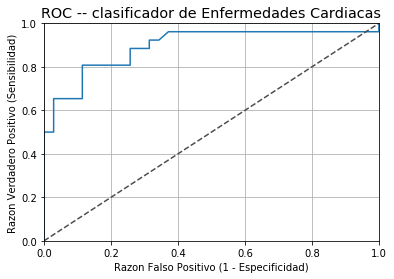

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC -- clasificador de Enfermedades Cardiacas')
plt.xlabel('Razon Falso Positivo (1 - Especificidad)')
plt.ylabel('Razon Verdadero Positivo (Sensibilidad)')
plt.grid(True)

Otra métrica común es el ** Área bajo la curva **, o ** AUC **. Esta es una forma conveniente de capturar el rendimiento de un modelo en un solo número, aunque no está exento de ciertos problemas. Como regla general, una AUC se puede clasificar de la siguiente manera.

- 0.90 - 1.00 = Excelente
- 0.80 - 0.90 = Bueno
- 0.70 - 0.80 = Justo
- 0.60 - 0.70 = Pobre
- 0.50 - 0.60 = Fallar

Veamos que nos da la ROC anterior.

In [23]:
auc(fpr, tpr)

0.893956043956044

Está bien, está funcionando bien.

<a id='section4'></a>

# La explicación

Una de las preguntas que se le puede hacer a un modelo es: ¿Qué características tienen el mayor impacto en las predicciones?

Este concepto se llama _importancia de la característica_.

Hay varias formas de medir la importancia de las características. Concentrese en uno: [**La importancia de la permutación**](https://www.kaggle.com/dansbecker/permutation-importance). En comparación con la mayoría de los otros enfoques, la importancia de la permutación es:


** La importancia de la permutación ** es una buena herramienta para comprender un modelo de aprendizaje automático, e implica mezclar variables individuales en los datos de validación (después de que un modelo se haya ajustado) y ver el efecto en la precisión. Aprende más 

Considere:


In [24]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Por lo tanto, parece que los factores más importantes en términos de permutación es el resultado de un numero mayor de venas de "defecto reversible". La importancia del tipo de 'frecuencia cardíaca máxima alcanzada' tiene sentido, ya que este es el estado subjetivo inmediato del paciente en el momento del examen (en oposición a, digamos, la edad, que es un factor mucho más general).

Eche un vistazo más de cerca a la cantidad de canales principales que utilizan un ** Gráfico de dependencia parcial **(aprenda más [aquí](https://www.kaggle.com/dansbecker/partial-plots)). Estas gráficas varían una sola variable en una sola fila a través de un rango de valores y ven qué efecto tiene en el resultado. Hace esto por varias filas y traza el efecto promedio. Echemos un vistazo a la variable 'num_major_vessels', que estaba en la parte superior de la lista de importancia de permutación.

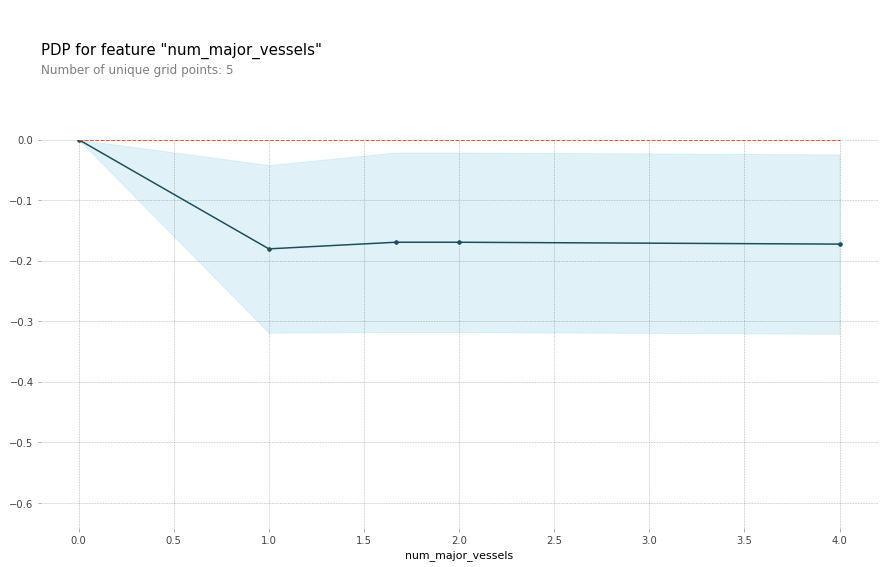

In [25]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Entonces, vea que a medida que aumenta el número de vasos sanguíneos importantes *, la probabilidad de enfermedad cardíaca * disminuye *. Eso tiene sentido, ya que significa que más sangre puede llegar al corazón.

¿Qué pasa con la _edad_?

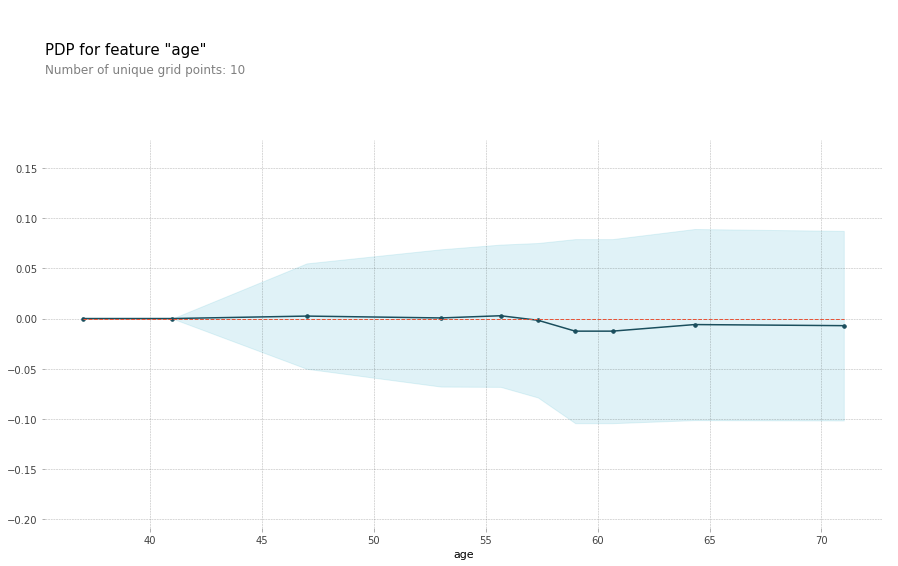

In [26]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Eso es un poco extraño. Cuanto mayor sea la edad, menor será la probabilidad de enfermedades del corazón? Aunque las regiones de confianza azul muestran que esto podría no ser cierto (la línea de base roja está dentro de la zona azul).

¿Qué pasa con el 'st_depression'?

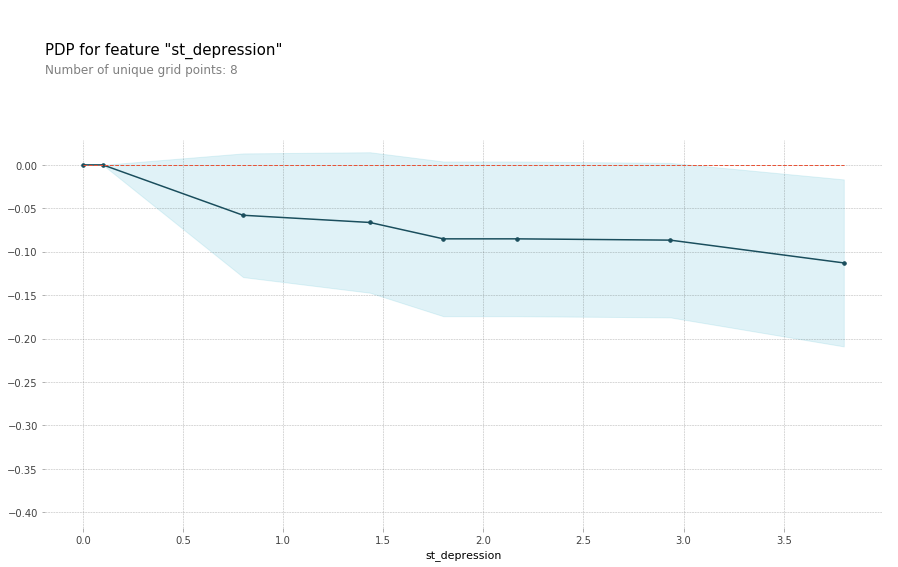

In [27]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Curiosamente, esta variable también muestra una reducción en la probabilidad a medida que aumenta. ¿Qué es exactamente esto? Una búsqueda en Google me llevó a la siguiente descripción de Anthony L. Komaroff, MD, un especialista en medicina interna [5](https://www.sharecare.com/health/circulatory-system-health/what-st-segment-electrocardiogram-ecg) .... * "Un electrocardiograma (ECG) mide la actividad eléctrica del corazón. Las ondas que aparecen en ella están etiquetadas como P, QRS y T. Cada uno corresponde a una parte diferente del latido del corazón. El ** segmento ST ** representa la actividad eléctrica del corazón inmediatamente después de que los ventrículos derecho e izquierdo se hayan contraído, bombeando sangre a los pulmones y al resto del cuerpo. Después de este gran esfuerzo, las células musculares ventriculares se relajan y se preparan para la siguiente contracción. Durante este período, fluye poca o ninguna electricidad, por lo que el segmento ST es uniforme con la línea de base o, a veces, ligeramente por encima de ella. Cuanto más rápido está latiendo el corazón durante un ECG, más cortas se vuelven todas las ondas. ** La forma y la dirección del segmento ST son mucho más importantes que su longitud. Los cambios hacia arriba o hacia abajo pueden representar una disminución del flujo sanguíneo al corazón debido a una variedad de causas, como ataque cardíaco, espasmos en una o más arterias coronarias (angina de Prinzmetal), infección del revestimiento del corazón (pericarditis) o el músculo del corazón mismo ( miocarditis), un exceso de potasio en el torrente sanguíneo, un problema del ritmo cardíaco o un coágulo de sangre en los pulmones (embolia pulmonar). "***

<img style="float: left;" src="https://www.cvphysiology.com/uploads/images/CAD012%20ST%20elevation.png" width="350px"/>    [6](https://www.cvphysiology.com/CAD/CAD012)

Entonces, esta variable, que se describe como "depresión del ST inducida por el ejercicio en relación con el reposo", parece sugerir que cuanto mayor sea el valor, mayor será la probabilidad de enfermedad cardíaca, pero la gráfica anterior muestra lo contrario. ¿Quizás no es solo la cantidad de depresión lo que es importante, sino la interacción con el tipo de pendiente? Vamos a ver con un PDP 2

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

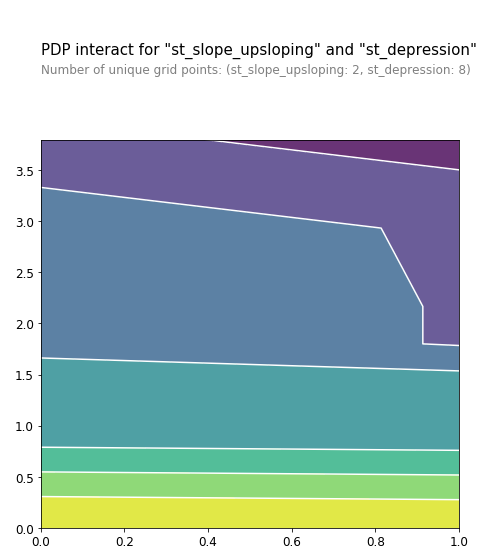

In [28]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

Parece que una depresión baja es mala en ambos casos. Impar.

Veamos qué nos dicen los valores de SHAP. Estos funcionan mostrando la influencia de los valores de cada variable en una sola fila, en comparación con sus valores de referencia (más información aquí(https://www.kaggle.com/dansbecker/shap-values)).

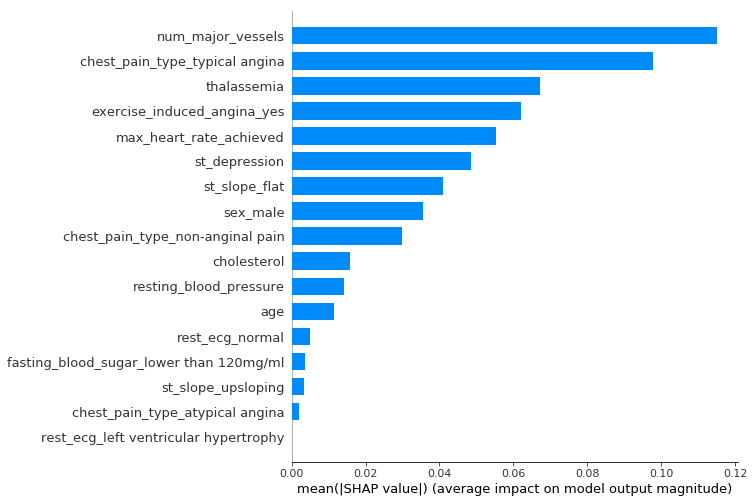

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

El número de buques principales está en la parte superior. Vamos a usar una gráfica de resumen de los valores SHAP.

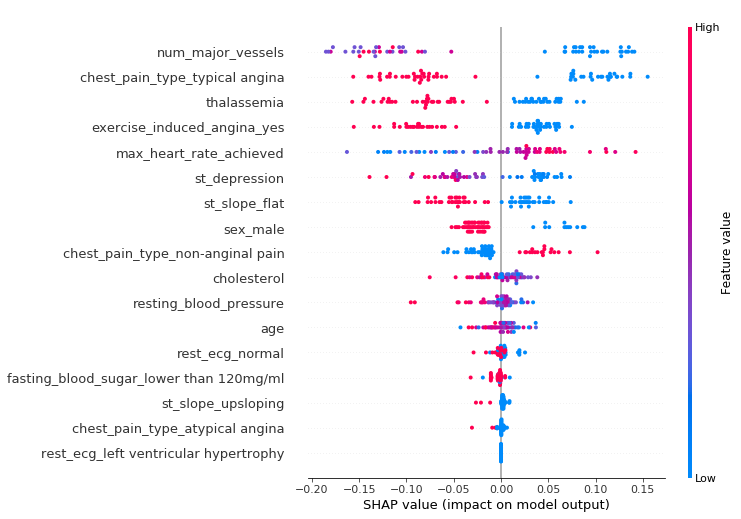

In [30]:
shap.summary_plot(shap_values[1], X_test)

El número de divisiones de buques principales es bastante claro, y se dice que los valores bajos son malos (azul a la derecha). La división de 'defecto reversible' de la talasemia es muy clara (sí = rojo = bueno, no = azul = malo).

Puedes ver una clara separación en muchas de las otras variables. La angina inducida por el ejercicio tiene una separación clara, aunque no como se esperaba, ya que 'no' (azul) * aumenta * la probabilidad. Otro claro es el st_slope. Parece que cuando es plano, es una mala señal (rojo a la derecha).

También es extraño que los hombres (rojo) tengan una * reducción * de probabilidad de sufrir enfermedades cardíacas en este modelo. ¿Por qué es esto? El conocimiento del dominio nos dice que los hombres tienen más posibilidades.

A continuación, seleccionemos pacientes individuales y veamos cómo las diferentes variables afectan sus resultados.

In [31]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [32]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

Para esta persona, su predicción es del 36% (en comparación con una línea de base del 58,4%). Muchas cosas están trabajando a su favor, incluyendo tener un vaso principal, un defecto de talasemia reversible y * no * tener un plano st_slope.

Vamos a ver otra:

In [33]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

Para esta persona, su predicción es del 70% (en comparación con una línea de base del 58,4%). No trabajar a su favor son cosas como no tener vasos importantes, una pendiente plana, y * no * un defecto reversible de talasemia.

We can also plot something called 'SHAP dependence contribution plots' (learn more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)). Que son bastante autoexplicativas en el contexto de los valores SHAP.

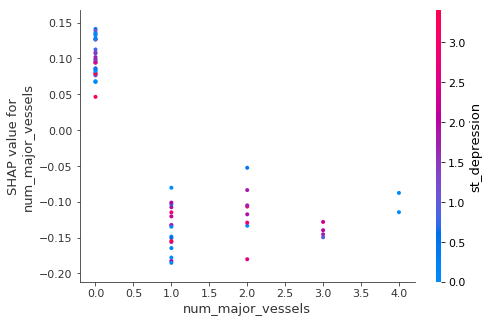

In [34]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

Se puede ver el efecto marcado en el número de embarcaciones principales, pero parece que no hay mucho que tomar del color. (st_depression).

La trama final, para mí, es una de las más efectivas. Muestra las predicciones y los factores de influencia para muchos pacientes (en este caso, 50), todos juntos. También es interactivo, lo que es genial. Pase el ratón para ver * por qué * cada persona terminó en rojo (predicción de enfermedad) o azul (predicción de no enfermedad).

In [35]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

<a id='section5'></a>

# Conclusión

Este conjunto de datos es antiguo y pequeño para los estándares de hoy. Sin embargo, nos permite crear un modelo simple y luego usar varias herramientas y técnicas de explicación de aprendizaje automático para echar un vistazo al interior. Al comienzo, formulé la hipótesis, utilizando el conocimiento del dominio (en Google) de que factores como el colesterol y la edad serían factores importantes en el modelo. Este conjunto de datos no mostró eso. En cambio, el número de factores y aspectos principales de los resultados del ECG dominó. ¡Realmente siento que he aprendido una o dos cosas sobre enfermedades del corazón!

Sospecho que este tipo de enfoque será cada vez más importante ya que el aprendizaje automático tiene un papel cada vez más importante en la atención médica.